In [1]:
import gc
import os
import random
from typing import List, Tuple

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer
from tqdm.notebook import tqdm

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

In [5]:
def find_best_rf(X: np.ndarray, y: np.ndarray) -> RandomForestClassifier:
    space = [
        Real(0.000001, 0.01, 'log-uniform', name='ccp_alpha'),
        Real(0.5, 0.85, 'uniform', name='max_features'),
        Real(0.6, 0.95, 'uniform', name='max_samples'),
        Integer(50, 1000, name='n_estimators')
    ]
    
    @use_named_args(space)
    def objective_f(ccp_alpha: float, max_features: float,
                    max_samples: float, n_estimators: int) -> float:
        test_cls = RandomForestClassifier(
            min_samples_leaf=5, n_estimators=n_estimators,
            random_state=42, verbose=True, n_jobs=-1,
            ccp_alpha=ccp_alpha, oob_score=True, bootstrap=True,
            max_samples=max_samples, max_features=max_features,
        )
        test_cls.fit(X, y)
        nd = len(test_cls.oob_decision_function_.shape)
        if nd != 2:
            err_msg = f'`oob_decision_function_` is wrong! ' \
                      f'Expected 2-D array, got {nd}-D one!'
            raise ValueError(err_msg)
        filtered = list(
            filter(
                lambda idx: not any(np.isnan(
                    test_cls.oob_decision_function_[idx]
                )),
                range(y.shape[0])
            )
        )
        info_msg = f'OOB score is estimated using {len(filtered)} ' \
                   f'samples from {y.shape[0]}.'
        print(info_msg)
        if len(filtered) < 3:
            err_msg = 'OOB score cannot be estimated!'
            raise ValueError(err_msg)
        quality = f1_score(
            y_true=y[filtered],
            y_pred=np.argmax(test_cls.oob_decision_function_[filtered],
                             axis=-1),
            average='macro'
        )
        return -quality
    
    res_gp = gp_minimize(
        objective_f, space,
        n_calls=32, n_random_starts=8,
        n_restarts_optimizer=4, random_state=42,
        verbose=True, n_jobs=1
    )
    best_parameters = {
        'ccp_alpha': float(res_gp.x[0]),
        'max_features': float(res_gp.x[1]),
        'max_samples': float(res_gp.x[2]),
        'n_estimators': int(res_gp.x[3]),
    }
    print(f'Best parameters are: {best_parameters}')
    final_cls = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=best_parameters['ccp_alpha'],
        n_estimators=best_parameters['n_estimators'],
        max_samples=best_parameters['max_samples'],
        max_features=best_parameters['max_features'],
    )
    final_cls.fit(X, y)
    return final_cls

In [6]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Tuple[Pipeline, List[str], \
                                                                    List[int]]:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    source_features = []
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        )
    ])
    preprocessor.fit(X)
    mask = preprocessor.named_steps['selector'].get_support(indices=False)
    assert len(mask) == len(source_features)
    selected_features = list(map(
        lambda idx2: source_features[idx2],
        filter(lambda idx1: mask[idx1], range(len(mask)))
    ))
    X_trans = preprocessor.transform(X)
    assert X_trans.shape[1] == len(selected_features)
    unique_values_list = []
    for ft_idx in range(X_trans.shape[1]):
        unique_values = set(map(lambda it: int(it), X_trans[:, ft_idx].tolist()))
        n_unique_values = len(unique_values)
        assert n_unique_values > 1
        unique_values_list.append(n_unique_values)
    return preprocessor, selected_features, unique_values_list

In [7]:
def build_normalizer(X: np.ndarray) -> Pipeline:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return normalizer.fit(X)

In [8]:
def build_neural_network(features: List[int], n_classes: int,
                         n_latent: int, n_hidden: int, depth: int,
                         dropout_rate: float,
                         nn_name: str) -> Tuple[tf.keras.Model, tf.keras.Model, \
                                                tf.keras.Model]:
    if n_hidden < 1:
        err_msg = f'The hidde layer size = {n_hidden} is too small!'
    binary_ft_indices = set()
    for ft_idx, ft_size in enumerate(features):
        if ft_size < 2:
            err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} is too small!'
            raise ValueError(err_msg)
        if ft_size == 2:
            binary_ft_indices.add(ft_idx)
    if (len(binary_ft_indices) > 0) and (len(binary_ft_indices) < len(features)):
        info_msg = f'There are {len(binary_ft_indices)} binary features and ' \
                   f'{len(features) - len(binary_ft_indices)} categorical features.'
    elif len(binary_ft_indices) > 0:
        info_msg = f'There are {len(binary_ft_indices)} binary features.'
    else:
        info_msg = f'There are {len(features)} categorical features.'
    print(info_msg)
    feature_vector = tf.keras.layers.Input(
        shape=(len(features),), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    encoder_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_enc_dropout1'
    )(feature_vector)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    encoder_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_enc_dense1'
    )(encoder_layer)
    for layer_idx in range(1, depth):
        encoder_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_enc_dropout{layer_idx + 1}'
        )(encoder_layer)
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        encoder_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx + 1}'
        )(encoder_layer)
    prior = tfp.distributions.Independent(
        distribution=tfp.distributions.Normal(
            loc=tf.zeros(n_latent),
            scale=1
        ),
        reinterpreted_batch_ndims=1
    )
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    latent_layer = tf.keras.layers.Dense(
        units=tfp.layers.IndependentNormal.params_size(n_latent),
        activation=None,
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_latent'
    )(encoder_layer)
    z = tfp.layers.IndependentNormal(
        event_shape=n_latent,
        convert_to_tensor_fn=tfp.distributions.Distribution.sample,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(
            distribution_b=prior,
            weight=1e-3
        ),
        name=f'{nn_name}_z'
    )(latent_layer)
    classifier_input = tf.keras.layers.Input(
        shape=(n_latent,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    hidden_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_cls_hidden'
    )(classifier_input)
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_cls_dropout'
    )(hidden_layer)
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_cls_output'
    )(hidden_layer)
    cls_name = f'{nn_name}_cls'
    cls_model = tf.keras.Model(
        inputs=classifier_input,
        outputs=cls_layer,
        name=cls_name
    )
    cls_model.build(input_shape=[None, n_latent])
    decoder_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dec_dropout1'
    )(z)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    decoder_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_dec_dense1'
    )(decoder_layer)
    for layer_idx in range(1, depth):
        decoder_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dec_dropout{layer_idx + 1}'
        )(decoder_layer)
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        decoder_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx + 1}'
        )(decoder_layer)
    reconstruction_layers = []
    reconstruction_names = []
    if len(binary_ft_indices) > 0:
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        new_reconstruction_layer = tf.keras.layers.Dense(
            units=len(binary_ft_indices),
            activation=None,
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_rec_binary'
        )(decoder_layer)
        new_reconstruction_name = f'{nn_name}_bernoulli'
        new_reconstruction_layer = tfp.layers.IndependentBernoulli(
            event_shape=len(binary_ft_indices),
            convert_to_tensor_fn=tfp.distributions.Bernoulli.logits,
            name=new_reconstruction_name
        )(new_reconstruction_layer)
        reconstruction_layers.append(new_reconstruction_layer)
        reconstruction_names.append(new_reconstruction_name)
    counter = 1
    for ft_idx, ft_size in enumerate(features):
        if ft_size > 2:
            try:
                kernel_initializer = tf.keras.initializers.LecunNormal(
                    seed=random.randint(0, 2147483647)
                )
            except:
                kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                    seed=random.randint(0, 2147483647)
                )
            new_reconstruction_layer = tf.keras.layers.Dense(
                units=ft_size,
                activation=None,
                kernel_initializer=kernel_initializer,
                bias_initializer='zeros',
                name=f'{nn_name}_rec_cat{counter}'
            )(decoder_layer)
            new_reconstruction_name = f'{nn_name}_categorical{counter}'
            new_reconstruction_layer = tfp.layers.OneHotCategorical(
                event_size=ft_size,
                convert_to_tensor_fn=tfp.distributions.OneHotCategorical.logits,
                name=new_reconstruction_name
            )(new_reconstruction_layer)
            reconstruction_layers.append(new_reconstruction_layer)
            reconstruction_names.append(new_reconstruction_name)
            counter += 1
    encoder_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=z,
        name=f'{nn_name}_enc'
    )
    united_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=[cls_model(z)] + reconstruction_layers,
        name=f'{nn_name}_vae'
    )
    encoder_model.build(input_shape=[None, len(features)])
    metrics = {cls_name: [tf.keras.metrics.CategoricalAccuracy()]}
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    losses = {
        cls_name: tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
    }
    loss_weights = {
        cls_name: 1.0
    }
    for cur_name in reconstruction_names:
        losses[cur_name] = negloglik
        loss_weights[cur_name] = 1.5
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    united_model.compile(optimizer=ranger, loss=losses, loss_weights=loss_weights,
                         metrics=metrics)
    return united_model, encoder_model, cls_model

In [9]:
def calculate_projections(X: np.ndarray, encoder: tf.keras.Model,
                          n_samples: int, batch_size: int) -> List[np.ndarray]:
    assert n_samples > 0
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    projections = [[] for _ in range(n_samples)]
    for batch_idx in tqdm(list(range(n_batches))):
        batch_start = batch_idx * batch_size
        batch_end = min(X.shape[0], batch_start + batch_size)
        distr = encoder(X[batch_start:batch_end])
        assert isinstance(distr, tfp.distributions.Distribution)
        if n_samples > 1:
            y_inst = distr.sample()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
            for prj_idx in range(1, n_samples):
                y_inst = distr.sample()
                if not isinstance(y_inst, np.ndarray):
                    y_inst = y_inst.numpy()
                assert len(y_inst.shape) == 2
                projections[prj_idx].append(y_inst)
                del y_inst
        else:
            y_inst = distr.mean()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[0].append(y_inst)
            del y_inst
        del distr
    return [np.vstack(cur) for cur in projections]

In [10]:
def predict_proba(X: np.ndarray, encoder: tf.keras.Model, classifier: tf.keras.Model,
                  n_samples: int, batch_size: int) -> np.ndarray:
    projections = calculate_projections(X, encoder, n_samples, batch_size)
    y = classifier.predict(projections[0], batch_size=batch_size)
    assert len(y.shape) == 2
    if n_samples > 1:
        for prj_idx in range(1, n_samples):
            y += classifier.predict(projections[prj_idx], batch_size=batch_size)
    proba = y.astype(np.float64) / float(n_samples)
    return proba / np.sum(proba, axis=1, keepdims=True)

In [11]:
class TrainsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        self.class_distr_ = dict()
        for sample_idx, class_idx in enumerate(y.tolist()):
            if class_idx in self.class_distr_:
                self.class_distr_[class_idx].append(sample_idx)
            else:
                self.class_distr_[class_idx] = [sample_idx]
        for class_idx in self.class_distr_:
            self.class_distr_[class_idx] = np.array(self.class_distr_[class_idx],
                                                    dtype=np.int32)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_indices = []
        selected_classes = sorted(list(self.class_distr_.keys()))
        if self.batch_size < len(selected_classes):
            selected_classes = random.sample(selected_classes, self.batch_size)
        for counter, class_idx in enumerate(selected_classes):
            n = int(round(
                (self.batch_size - len(batch_indices)) / 
                (len(selected_classes) - counter)
            ))
            batch_indices += np.random.choice(
                a=self.class_distr_[class_idx],
                size=n
            ).tolist()
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [12]:
class ValidsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_start = batch_idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.x_src.shape[0])
        batch_indices = list(range(batch_start, batch_end))
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [13]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [14]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
MINIBATCH_SIZE_FOR_TRAINING = 4096
MINIBATCH_SIZE_FOR_INFERENCE = 32
MAX_TRAINING_EPOCHS = 1000
ES_PATIENCE = 20

In [16]:
dataset = fetch_covtype(return_X_y=False, random_state=42, shuffle=True)

In [17]:
classes_dict = dict()
for val in dataset.target.tolist():
    if val not in classes_dict:
        classes_dict[val] = len(classes_dict)

In [18]:
print(f'X.shape = {dataset.data.shape}')
print(f'y.shape = {dataset.target.shape}')
print(f'Number of classes is {len(classes_dict)}.')

X.shape = (581012, 54)
y.shape = (581012,)
Number of classes is 7.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    np.array([classes_dict[val] for val in dataset.target.tolist()], dtype=np.int32),
    test_size=0.05, stratify=dataset.target, random_state=42
)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05, stratify=y_train, random_state=42
)

In [21]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
number_of_classes_for_training = len(set(map(lambda it: int(it), y_train.tolist())))
print(f'Number of classes is {number_of_classes_for_training}.')

X_train.shape = (524362, 54)
y_train.shape = (524362,)
Number of classes is 7.


In [22]:
print(f'X_valid.shape = {X_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
number_of_classes_for_validation = len(set(map(lambda it: int(it), y_valid.tolist())))
print(f'Number of classes is {number_of_classes_for_validation}.')

X_valid.shape = (27599, 54)
y_valid.shape = (27599,)
Number of classes is 7.


In [23]:
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
number_of_classes_for_testing = len(set(map(lambda it: int(it), y_test.tolist())))
print(f'Number of classes is {number_of_classes_for_testing}.')

X_test.shape = (29051, 54)
y_test.shape = (29051,)
Number of classes is 7.


In [24]:
BEST_RF_PARAMS = {'ccp_alpha': 1e-06, 'max_features': 0.85, 'max_samples': 0.95, 'n_estimators': 1000}

In [25]:
if BEST_RF_PARAMS is None:
    baseline = find_best_rf(X_train, y_train)
else:
    baseline = RandomForestClassifier(
        min_samples_leaf=5, random_state=42, verbose=True, n_jobs=-1,
        oob_score=True, bootstrap=True,
        ccp_alpha=BEST_RF_PARAMS['ccp_alpha'],
        n_estimators=BEST_RF_PARAMS['n_estimators'],
        max_samples=BEST_RF_PARAMS['max_samples'],
        max_features=BEST_RF_PARAMS['max_features']
    ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished


In [26]:
print(classification_report(y_true=y_valid, y_pred=baseline.predict(X_valid),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.7s


              precision    recall  f1-score   support

           0     0.9709    0.9592    0.9650     10063
           1     0.9647    0.9777    0.9711     13457
           2     0.9461    0.9723    0.9590      1698
           3     0.9350    0.8293    0.8790       451
           4     0.9468    0.9067    0.9263       825
           5     0.9688    0.9559    0.9623       974
           6     0.9268    0.8702    0.8976       131

    accuracy                         0.9648     27599
   macro avg     0.9513    0.9245    0.9372     27599
weighted avg     0.9648    0.9648    0.9647     27599



[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [27]:
print(classification_report(y_true=y_test, y_pred=baseline.predict(X_test),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.8s


              precision    recall  f1-score   support

           0     0.9703    0.9576    0.9639     10592
           1     0.9630    0.9780    0.9704     14165
           2     0.9542    0.9681    0.9611      1788
           3     0.9512    0.8211    0.8814       475
           4     0.9347    0.9240    0.9293       868
           5     0.9729    0.9464    0.9595      1026
           6     0.9091    0.8759    0.8922       137

    accuracy                         0.9642     29051
   macro avg     0.9508    0.9244    0.9368     29051
weighted avg     0.9642    0.9642    0.9640     29051



[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [28]:
input_preprocessor, input_names, input_categories = build_preprocessor(
    X=X_train,
    colnames=dataset.feature_names
)

Column 0 "Elevation" has 1968 unique values.
Column 1 "Aspect" has 361 unique values.
Column 2 "Slope" has 66 unique values.
Column 3 "Horizontal_Distance_To_Hydrology" has 550 unique values.
Column 4 "Vertical_Distance_To_Hydrology" has 696 unique values.
Column 5 "Horizontal_Distance_To_Roadways" has 5770 unique values.
Column 6 "Hillshade_9am" has 207 unique values.
Column 7 "Hillshade_Noon" has 184 unique values.
Column 8 "Hillshade_3pm" has 255 unique values.
Column 9 "Horizontal_Distance_To_Fire_Points" has 5813 unique values.
Column 10 "Wilderness_Area_0" has 2 unique values.
Column 11 "Wilderness_Area_1" has 2 unique values.
Column 12 "Wilderness_Area_2" has 2 unique values.
Column 13 "Wilderness_Area_3" has 2 unique values.
Column 14 "Soil_Type_0" has 2 unique values.
Column 15 "Soil_Type_1" has 2 unique values.
Column 16 "Soil_Type_2" has 2 unique values.
Column 17 "Soil_Type_3" has 2 unique values.
Column 18 "Soil_Type_4" has 2 unique values.
Column 19 "Soil_Type_5" has 2 un

C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8

In [29]:
del dataset

In [30]:
X_train_quantized = input_preprocessor.transform(X_train)
X_valid_quantized = input_preprocessor.transform(X_valid)

In [31]:
for feature_index, feature_name in enumerate(input_names):
    print(f'{feature_name} has {input_categories[feature_index]} unique values.')

Elevation has 256 unique values.
Aspect has 119 unique values.
Slope has 21 unique values.
Horizontal_Distance_To_Hydrology has 109 unique values.
Vertical_Distance_To_Hydrology has 146 unique values.
Horizontal_Distance_To_Roadways has 256 unique values.
Hillshade_9am has 64 unique values.
Hillshade_Noon has 54 unique values.
Hillshade_3pm has 85 unique values.
Horizontal_Distance_To_Fire_Points has 256 unique values.
Wilderness_Area_0 has 2 unique values.
Wilderness_Area_1 has 2 unique values.
Wilderness_Area_2 has 2 unique values.
Wilderness_Area_3 has 2 unique values.
Soil_Type_0 has 2 unique values.
Soil_Type_1 has 2 unique values.
Soil_Type_2 has 2 unique values.
Soil_Type_3 has 2 unique values.
Soil_Type_4 has 2 unique values.
Soil_Type_5 has 2 unique values.
Soil_Type_6 has 2 unique values.
Soil_Type_7 has 2 unique values.
Soil_Type_8 has 2 unique values.
Soil_Type_9 has 2 unique values.
Soil_Type_10 has 2 unique values.
Soil_Type_11 has 2 unique values.
Soil_Type_12 has 2 uniq

In [32]:
print(f'Total number of unique values is {sum(input_categories)}.')

Total number of unique values is 1454.


In [33]:
input_normalizer = build_normalizer(X_train)

In [34]:
X_train = input_normalizer.transform(X_train)
X_valid = input_normalizer.transform(X_valid)
X_test = input_normalizer.transform(X_test)

In [35]:
trainset_gen = TrainsetGenerator(
    x_src=X_train_quantized,
    x_norm=X_train,
    y=y_train,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [36]:
X_, y_ = trainset_gen[0]
print(X_[0])
for it in y_:
    print(it[0].tolist() if isinstance(it[0], np.ndarray) else it[0])
del X_, y_

[ 3.1698352e-01 -1.2436310e+00 -9.8235929e-01 -1.0195646e+00
  5.8616734e-01 -1.1568286e+00 -1.5181400e-01  2.4146403e-01
 -7.7954209e-01  1.8961939e+00 -1.3411260e+00  1.7255381e+00
 -1.4771707e+00  2.3777629e-01  2.5964335e-01 -7.7618486e-01
  2.9072332e-01 -4.9969864e-01 -7.5002897e-01 -4.4066715e-01
  1.3812125e-01 -5.5963403e-01 -1.6686271e-01 -1.1624459e-01
  1.7178836e-01  6.8602934e-02 -5.8058649e-02 -1.5387362e-01
  2.3957362e-02 -7.5299077e-02 -1.4331256e-02 -5.1747737e-03
 -1.1314893e-02  4.6810280e-03 -3.4542501e-02 -4.7419462e-02
 -1.7947195e-02  2.9625800e-03 -1.6188375e-03  1.6398565e-01
  1.1993968e+00 -2.0458321e-01  6.9995165e-01 -1.7208570e-01
 -6.1011755e-01 -1.1995329e+00 -9.1859698e-02 -5.2674448e-01
  1.0425091e+00  4.5667589e-01  7.8531253e-01  1.3355339e-03
 -4.3550673e-15 -6.1737050e-16]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [37]:
train_class_freq = dict()
for idx1 in range(len(trainset_gen)):
    X_, y_ = trainset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in train_class_freq:
            train_class_freq[class_idx1] += 1
        else:
            train_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(train_class_freq.keys()):
    sum_freq += train_class_freq[class_idx1]
for class_idx1 in sorted(train_class_freq.keys()):
    percent = 100.0 * train_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 14%.
Class 1 frequency is 14%.
Class 2 frequency is 14%.
Class 3 frequency is 14%.
Class 4 frequency is 14%.
Class 5 frequency is 14%.
Class 6 frequency is 14%.


In [38]:
validset_gen = ValidsetGenerator(
    x_src=X_valid_quantized,
    x_norm=X_valid,
    y=y_valid,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [39]:
val_class_freq = dict()
for idx1 in range(len(validset_gen)):
    X_, y_ = validset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in val_class_freq:
            val_class_freq[class_idx1] += 1
        else:
            val_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(val_class_freq.keys()):
    sum_freq += val_class_freq[class_idx1]
for class_idx1 in sorted(val_class_freq.keys()):
    percent = 100.0 * val_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 36%.
Class 1 frequency is 49%.
Class 2 frequency is 6%.
Class 3 frequency is 2%.
Class 4 frequency is 3%.
Class 5 frequency is 4%.
Class 6 frequency is 0%.


In [40]:
trainable_nn, encoding_nn, classification_nn = build_neural_network(
    features=input_categories, n_classes=len(classes_dict), n_latent=64, n_hidden=512,
    depth=12, dropout_rate=1e-5, nn_name='covertype'
)

There are 44 binary features and 10 categorical features.


In [41]:
trainable_nn.summary()

Model: "covertype_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
covertype_feature_vector (Input [(None, 54)]         0                                            
__________________________________________________________________________________________________
covertype_enc_dropout1 (AlphaDr (None, 54)           0           covertype_feature_vector[0][0]   
__________________________________________________________________________________________________
covertype_enc_dense1 (Dense)    (None, 512)          28160       covertype_enc_dropout1[0][0]     
__________________________________________________________________________________________________
covertype_enc_dropout2 (AlphaDr (None, 512)          0           covertype_enc_dense1[0][0]       
______________________________________________________________________________________

In [42]:
nn_fname = 'covertype_united.h5'

In [43]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=ES_PATIENCE,
        mode="min",
        restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=nn_fname,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )
]

In [44]:
model_history = trainable_nn.fit(trainset_gen, validation_data=validset_gen,
                                 epochs=MAX_TRAINING_EPOCHS, callbacks=callbacks,
                                 verbose=1)

Epoch 1/1000
129/129 [==============================] - 47s 220ms/step - loss: 73.7943 - covertype_cls_loss: 1.2101 - covertype_bernoulli_loss: 4.0044 - covertype_categorical1_loss: 4.8896 - covertype_categorical2_loss: 4.6832 - covertype_categorical3_loss: 2.5523 - covertype_categorical4_loss: 4.2303 - covertype_categorical5_loss: 4.7577 - covertype_categorical6_loss: 5.6078 - covertype_categorical7_loss: 3.8577 - covertype_categorical8_loss: 3.8207 - covertype_categorical9_loss: 4.1559 - covertype_categorical10_loss: 5.6422 - covertype_cls_categorical_accuracy: 0.5825 - val_loss: 64.5001 - val_covertype_cls_loss: 1.0911 - val_covertype_bernoulli_loss: 0.8075 - val_covertype_categorical1_loss: 5.3048 - val_covertype_categorical2_loss: 3.9638 - val_covertype_categorical3_loss: 2.0860 - val_covertype_categorical4_loss: 4.1449 - val_covertype_categorical5_loss: 4.6012 - val_covertype_categorical6_loss: 5.4959 - val_covertype_categorical7_loss: 3.2637 - val_covertype_categorical8_loss: 3.

129/129 [==============================] - 30s 236ms/step - loss: 37.1145 - covertype_cls_loss: 0.6132 - covertype_bernoulli_loss: 0.0937 - covertype_categorical1_loss: 2.6839 - covertype_categorical2_loss: 1.9333 - covertype_categorical3_loss: 0.8681 - covertype_categorical4_loss: 2.5396 - covertype_categorical5_loss: 3.1418 - covertype_categorical6_loss: 3.6120 - covertype_categorical7_loss: 1.7013 - covertype_categorical8_loss: 1.6962 - covertype_categorical9_loss: 1.9479 - covertype_categorical10_loss: 3.7931 - covertype_cls_categorical_accuracy: 0.8485 - val_loss: 41.3611 - val_covertype_cls_loss: 0.8282 - val_covertype_bernoulli_loss: 0.1214 - val_covertype_categorical1_loss: 3.8583 - val_covertype_categorical2_loss: 1.9167 - val_covertype_categorical3_loss: 0.8548 - val_covertype_categorical4_loss: 2.8540 - val_covertype_categorical5_loss: 3.4293 - val_covertype_categorical6_loss: 4.0259 - val_covertype_categorical7_loss: 1.7661 - val_covertype_categorical8_loss: 1.6441 - val_co

129/129 [==============================] - 28s 218ms/step - loss: 31.5264 - covertype_cls_loss: 0.5362 - covertype_bernoulli_loss: 0.0551 - covertype_categorical1_loss: 2.2552 - covertype_categorical2_loss: 1.6410 - covertype_categorical3_loss: 0.7028 - covertype_categorical4_loss: 2.2032 - covertype_categorical5_loss: 2.7371 - covertype_categorical6_loss: 3.0083 - covertype_categorical7_loss: 1.4456 - covertype_categorical8_loss: 1.4461 - covertype_categorical9_loss: 1.6550 - covertype_categorical10_loss: 3.1636 - covertype_cls_categorical_accuracy: 0.8863 - val_loss: 42.1221 - val_covertype_cls_loss: 0.7494 - val_covertype_bernoulli_loss: 0.0858 - val_covertype_categorical1_loss: 3.6486 - val_covertype_categorical2_loss: 2.1683 - val_covertype_categorical3_loss: 1.1574 - val_covertype_categorical4_loss: 2.8194 - val_covertype_categorical5_loss: 3.3154 - val_covertype_categorical6_loss: 3.7480 - val_covertype_categorical7_loss: 1.9580 - val_covertype_categorical8_loss: 2.0616 - val_co

129/129 [==============================] - 30s 229ms/step - loss: 27.9267 - covertype_cls_loss: 0.4948 - covertype_bernoulli_loss: 0.0448 - covertype_categorical1_loss: 2.0163 - covertype_categorical2_loss: 1.4384 - covertype_categorical3_loss: 0.5802 - covertype_categorical4_loss: 1.9769 - covertype_categorical5_loss: 2.4864 - covertype_categorical6_loss: 2.6311 - covertype_categorical7_loss: 1.2569 - covertype_categorical8_loss: 1.2594 - covertype_categorical9_loss: 1.4467 - covertype_categorical10_loss: 2.7904 - covertype_cls_categorical_accuracy: 0.9064 - val_loss: 34.9579 - val_covertype_cls_loss: 0.6730 - val_covertype_bernoulli_loss: 0.0603 - val_covertype_categorical1_loss: 3.3763 - val_covertype_categorical2_loss: 1.5854 - val_covertype_categorical3_loss: 0.5281 - val_covertype_categorical4_loss: 2.4824 - val_covertype_categorical5_loss: 2.9937 - val_covertype_categorical6_loss: 3.4514 - val_covertype_categorical7_loss: 1.4130 - val_covertype_categorical8_loss: 1.3407 - val_co

129/129 [==============================] - 32s 250ms/step - loss: 25.0727 - covertype_cls_loss: 0.4642 - covertype_bernoulli_loss: 0.0359 - covertype_categorical1_loss: 1.8229 - covertype_categorical2_loss: 1.2761 - covertype_categorical3_loss: 0.4930 - covertype_categorical4_loss: 1.7719 - covertype_categorical5_loss: 2.2548 - covertype_categorical6_loss: 2.3413 - covertype_categorical7_loss: 1.1140 - covertype_categorical8_loss: 1.1178 - covertype_categorical9_loss: 1.2808 - covertype_categorical10_loss: 2.5304 - covertype_cls_categorical_accuracy: 0.9202 - val_loss: 36.7960 - val_covertype_cls_loss: 0.6470 - val_covertype_bernoulli_loss: 0.0738 - val_covertype_categorical1_loss: 3.3924 - val_covertype_categorical2_loss: 1.7827 - val_covertype_categorical3_loss: 0.7104 - val_covertype_categorical4_loss: 2.5075 - val_covertype_categorical5_loss: 2.9888 - val_covertype_categorical6_loss: 3.4801 - val_covertype_categorical7_loss: 1.7474 - val_covertype_categorical8_loss: 1.4676 - val_co

129/129 [==============================] - 30s 234ms/step - loss: 23.2018 - covertype_cls_loss: 0.4465 - covertype_bernoulli_loss: 0.0351 - covertype_categorical1_loss: 1.6981 - covertype_categorical2_loss: 1.1841 - covertype_categorical3_loss: 0.4422 - covertype_categorical4_loss: 1.6138 - covertype_categorical5_loss: 2.0920 - covertype_categorical6_loss: 2.1636 - covertype_categorical7_loss: 1.0480 - covertype_categorical8_loss: 1.0201 - covertype_categorical9_loss: 1.2032 - covertype_categorical10_loss: 2.2996 - covertype_cls_categorical_accuracy: 0.9281 - val_loss: 32.7356 - val_covertype_cls_loss: 0.6040 - val_covertype_bernoulli_loss: 0.0558 - val_covertype_categorical1_loss: 3.1696 - val_covertype_categorical2_loss: 1.5071 - val_covertype_categorical3_loss: 0.4503 - val_covertype_categorical4_loss: 2.2862 - val_covertype_categorical5_loss: 2.8280 - val_covertype_categorical6_loss: 3.2680 - val_covertype_categorical7_loss: 1.3126 - val_covertype_categorical8_loss: 1.2279 - val_co

129/129 [==============================] - 32s 252ms/step - loss: 21.7959 - covertype_cls_loss: 0.4352 - covertype_bernoulli_loss: 0.0354 - covertype_categorical1_loss: 1.5997 - covertype_categorical2_loss: 1.0890 - covertype_categorical3_loss: 0.4194 - covertype_categorical4_loss: 1.5502 - covertype_categorical5_loss: 2.0132 - covertype_categorical6_loss: 2.0044 - covertype_categorical7_loss: 0.9809 - covertype_categorical8_loss: 0.9314 - covertype_categorical9_loss: 1.0975 - covertype_categorical10_loss: 2.1466 - covertype_cls_categorical_accuracy: 0.9327 - val_loss: 33.0518 - val_covertype_cls_loss: 0.6054 - val_covertype_bernoulli_loss: 0.0597 - val_covertype_categorical1_loss: 3.2172 - val_covertype_categorical2_loss: 1.4829 - val_covertype_categorical3_loss: 0.4361 - val_covertype_categorical4_loss: 2.4272 - val_covertype_categorical5_loss: 2.9019 - val_covertype_categorical6_loss: 3.3091 - val_covertype_categorical7_loss: 1.2672 - val_covertype_categorical8_loss: 1.2230 - val_co

129/129 [==============================] - 30s 230ms/step - loss: 20.1610 - covertype_cls_loss: 0.4171 - covertype_bernoulli_loss: 0.0298 - covertype_categorical1_loss: 1.4931 - covertype_categorical2_loss: 0.9849 - covertype_categorical3_loss: 0.3592 - covertype_categorical4_loss: 1.4766 - covertype_categorical5_loss: 1.9068 - covertype_categorical6_loss: 1.8490 - covertype_categorical7_loss: 0.8612 - covertype_categorical8_loss: 0.8574 - covertype_categorical9_loss: 0.9932 - covertype_categorical10_loss: 1.9771 - covertype_cls_categorical_accuracy: 0.9405 - val_loss: 34.9510 - val_covertype_cls_loss: 0.5694 - val_covertype_bernoulli_loss: 0.0788 - val_covertype_categorical1_loss: 3.1088 - val_covertype_categorical2_loss: 1.6782 - val_covertype_categorical3_loss: 0.9048 - val_covertype_categorical4_loss: 2.2633 - val_covertype_categorical5_loss: 2.9824 - val_covertype_categorical6_loss: 3.2052 - val_covertype_categorical7_loss: 1.5739 - val_covertype_categorical8_loss: 1.5889 - val_co

129/129 [==============================] - 32s 248ms/step - loss: 18.4456 - covertype_cls_loss: 0.4060 - covertype_bernoulli_loss: 0.0254 - covertype_categorical1_loss: 1.3888 - covertype_categorical2_loss: 0.9506 - covertype_categorical3_loss: 0.2662 - covertype_categorical4_loss: 1.3067 - covertype_categorical5_loss: 1.7064 - covertype_categorical6_loss: 1.6963 - covertype_categorical7_loss: 0.8278 - covertype_categorical8_loss: 0.7459 - covertype_categorical9_loss: 0.9156 - covertype_categorical10_loss: 1.8213 - covertype_cls_categorical_accuracy: 0.9452 - val_loss: 32.9858 - val_covertype_cls_loss: 0.5826 - val_covertype_bernoulli_loss: 0.0653 - val_covertype_categorical1_loss: 3.1884 - val_covertype_categorical2_loss: 1.5105 - val_covertype_categorical3_loss: 0.5264 - val_covertype_categorical4_loss: 2.2877 - val_covertype_categorical5_loss: 2.8461 - val_covertype_categorical6_loss: 3.2743 - val_covertype_categorical7_loss: 1.2760 - val_covertype_categorical8_loss: 1.2942 - val_co

129/129 [==============================] - 32s 248ms/step - loss: 17.8683 - covertype_cls_loss: 0.4004 - covertype_bernoulli_loss: 0.0291 - covertype_categorical1_loss: 1.3458 - covertype_categorical2_loss: 0.9106 - covertype_categorical3_loss: 0.2847 - covertype_categorical4_loss: 1.2783 - covertype_categorical5_loss: 1.6676 - covertype_categorical6_loss: 1.6273 - covertype_categorical7_loss: 0.7510 - covertype_categorical8_loss: 0.7917 - covertype_categorical9_loss: 0.8509 - covertype_categorical10_loss: 1.7333 - covertype_cls_categorical_accuracy: 0.9476 - val_loss: 31.7072 - val_covertype_cls_loss: 0.5677 - val_covertype_bernoulli_loss: 0.0575 - val_covertype_categorical1_loss: 3.0355 - val_covertype_categorical2_loss: 1.4888 - val_covertype_categorical3_loss: 0.4571 - val_covertype_categorical4_loss: 2.2279 - val_covertype_categorical5_loss: 2.8104 - val_covertype_categorical6_loss: 3.1194 - val_covertype_categorical7_loss: 1.2463 - val_covertype_categorical8_loss: 1.2322 - val_co

129/129 [==============================] - 33s 258ms/step - loss: 18.0112 - covertype_cls_loss: 0.4137 - covertype_bernoulli_loss: 0.0479 - covertype_categorical1_loss: 1.3439 - covertype_categorical2_loss: 0.8382 - covertype_categorical3_loss: 0.3432 - covertype_categorical4_loss: 1.3250 - covertype_categorical5_loss: 1.7645 - covertype_categorical6_loss: 1.6128 - covertype_categorical7_loss: 0.7380 - covertype_categorical8_loss: 0.7563 - covertype_categorical9_loss: 0.8647 - covertype_categorical10_loss: 1.7201 - covertype_cls_categorical_accuracy: 0.9433 - val_loss: 33.9987 - val_covertype_cls_loss: 0.5596 - val_covertype_bernoulli_loss: 0.0748 - val_covertype_categorical1_loss: 3.1514 - val_covertype_categorical2_loss: 1.6059 - val_covertype_categorical3_loss: 0.7290 - val_covertype_categorical4_loss: 2.2800 - val_covertype_categorical5_loss: 2.8673 - val_covertype_categorical6_loss: 3.2827 - val_covertype_categorical7_loss: 1.3811 - val_covertype_categorical8_loss: 1.4589 - val_co

129/129 [==============================] - 29s 228ms/step - loss: 15.7127 - covertype_cls_loss: 0.3843 - covertype_bernoulli_loss: 0.0234 - covertype_categorical1_loss: 1.2165 - covertype_categorical2_loss: 0.7935 - covertype_categorical3_loss: 0.2378 - covertype_categorical4_loss: 1.0810 - covertype_categorical5_loss: 1.4277 - covertype_categorical6_loss: 1.4342 - covertype_categorical7_loss: 0.6844 - covertype_categorical8_loss: 0.6406 - covertype_categorical9_loss: 0.7701 - covertype_categorical10_loss: 1.5324 - covertype_cls_categorical_accuracy: 0.9542 - val_loss: 30.4408 - val_covertype_cls_loss: 0.5215 - val_covertype_bernoulli_loss: 0.0490 - val_covertype_categorical1_loss: 2.9736 - val_covertype_categorical2_loss: 1.3845 - val_covertype_categorical3_loss: 0.3111 - val_covertype_categorical4_loss: 2.1234 - val_covertype_categorical5_loss: 2.7818 - val_covertype_categorical6_loss: 3.1112 - val_covertype_categorical7_loss: 1.1273 - val_covertype_categorical8_loss: 1.0676 - val_co

129/129 [==============================] - 31s 238ms/step - loss: 16.3653 - covertype_cls_loss: 0.3904 - covertype_bernoulli_loss: 0.0313 - covertype_categorical1_loss: 1.2276 - covertype_categorical2_loss: 0.8001 - covertype_categorical3_loss: 0.2735 - covertype_categorical4_loss: 1.2137 - covertype_categorical5_loss: 1.5811 - covertype_categorical6_loss: 1.4484 - covertype_categorical7_loss: 0.6854 - covertype_categorical8_loss: 0.6751 - covertype_categorical9_loss: 0.7942 - covertype_categorical10_loss: 1.5413 - covertype_cls_categorical_accuracy: 0.9520 - val_loss: 31.6234 - val_covertype_cls_loss: 0.5274 - val_covertype_bernoulli_loss: 0.0642 - val_covertype_categorical1_loss: 3.0803 - val_covertype_categorical2_loss: 1.4486 - val_covertype_categorical3_loss: 0.3384 - val_covertype_categorical4_loss: 2.2001 - val_covertype_categorical5_loss: 2.8749 - val_covertype_categorical6_loss: 3.2344 - val_covertype_categorical7_loss: 1.2059 - val_covertype_categorical8_loss: 1.1087 - val_co

129/129 [==============================] - 31s 239ms/step - loss: 14.9029 - covertype_cls_loss: 0.3784 - covertype_bernoulli_loss: 0.0251 - covertype_categorical1_loss: 1.1569 - covertype_categorical2_loss: 0.7129 - covertype_categorical3_loss: 0.2904 - covertype_categorical4_loss: 1.0179 - covertype_categorical5_loss: 1.3351 - covertype_categorical6_loss: 1.3342 - covertype_categorical7_loss: 0.6385 - covertype_categorical8_loss: 0.6420 - covertype_categorical9_loss: 0.7309 - covertype_categorical10_loss: 1.4215 - covertype_cls_categorical_accuracy: 0.9569 - val_loss: 30.4752 - val_covertype_cls_loss: 0.5118 - val_covertype_bernoulli_loss: 0.0456 - val_covertype_categorical1_loss: 2.9537 - val_covertype_categorical2_loss: 1.4278 - val_covertype_categorical3_loss: 0.2895 - val_covertype_categorical4_loss: 2.1062 - val_covertype_categorical5_loss: 2.7867 - val_covertype_categorical6_loss: 3.0943 - val_covertype_categorical7_loss: 1.1856 - val_covertype_categorical8_loss: 1.0733 - val_co

129/129 [==============================] - 31s 238ms/step - loss: 14.4518 - covertype_cls_loss: 0.3760 - covertype_bernoulli_loss: 0.0264 - covertype_categorical1_loss: 1.1371 - covertype_categorical2_loss: 0.6838 - covertype_categorical3_loss: 0.2262 - covertype_categorical4_loss: 1.0462 - covertype_categorical5_loss: 1.3263 - covertype_categorical6_loss: 1.3057 - covertype_categorical7_loss: 0.5919 - covertype_categorical8_loss: 0.5900 - covertype_categorical9_loss: 0.6754 - covertype_categorical10_loss: 1.3999 - covertype_cls_categorical_accuracy: 0.9578 - val_loss: 48.0382 - val_covertype_cls_loss: 0.5189 - val_covertype_bernoulli_loss: 0.1071 - val_covertype_categorical1_loss: 3.1556 - val_covertype_categorical2_loss: 3.1458 - val_covertype_categorical3_loss: 2.3333 - val_covertype_categorical4_loss: 2.3486 - val_covertype_categorical5_loss: 2.9588 - val_covertype_categorical6_loss: 3.3431 - val_covertype_categorical7_loss: 3.9448 - val_covertype_categorical8_loss: 2.4203 - val_co

129/129 [==============================] - 30s 234ms/step - loss: 13.3708 - covertype_cls_loss: 0.3678 - covertype_bernoulli_loss: 0.0213 - covertype_categorical1_loss: 1.0793 - covertype_categorical2_loss: 0.6158 - covertype_categorical3_loss: 0.1650 - covertype_categorical4_loss: 1.0095 - covertype_categorical5_loss: 1.2440 - covertype_categorical6_loss: 1.2170 - covertype_categorical7_loss: 0.5244 - covertype_categorical8_loss: 0.5161 - covertype_categorical9_loss: 0.6030 - covertype_categorical10_loss: 1.2998 - covertype_cls_categorical_accuracy: 0.9613 - val_loss: 30.1324 - val_covertype_cls_loss: 0.5060 - val_covertype_bernoulli_loss: 0.0479 - val_covertype_categorical1_loss: 2.9294 - val_covertype_categorical2_loss: 1.3454 - val_covertype_categorical3_loss: 0.2696 - val_covertype_categorical4_loss: 2.1279 - val_covertype_categorical5_loss: 2.8486 - val_covertype_categorical6_loss: 3.1125 - val_covertype_categorical7_loss: 1.0721 - val_covertype_categorical8_loss: 1.0482 - val_co

129/129 [==============================] - 30s 235ms/step - loss: 13.1907 - covertype_cls_loss: 0.3676 - covertype_bernoulli_loss: 0.0234 - covertype_categorical1_loss: 1.0745 - covertype_categorical2_loss: 0.5894 - covertype_categorical3_loss: 0.1612 - covertype_categorical4_loss: 1.0069 - covertype_categorical5_loss: 1.2824 - covertype_categorical6_loss: 1.1949 - covertype_categorical7_loss: 0.5000 - covertype_categorical8_loss: 0.4956 - covertype_categorical9_loss: 0.5713 - covertype_categorical10_loss: 1.2757 - covertype_cls_categorical_accuracy: 0.9614 - val_loss: 32.5712 - val_covertype_cls_loss: 0.5122 - val_covertype_bernoulli_loss: 0.0635 - val_covertype_categorical1_loss: 3.0529 - val_covertype_categorical2_loss: 1.5411 - val_covertype_categorical3_loss: 0.4674 - val_covertype_categorical4_loss: 2.2857 - val_covertype_categorical5_loss: 2.9850 - val_covertype_categorical6_loss: 3.2339 - val_covertype_categorical7_loss: 1.2888 - val_covertype_categorical8_loss: 1.2380 - val_co

129/129 [==============================] - 30s 232ms/step - loss: 13.0140 - covertype_cls_loss: 0.3645 - covertype_bernoulli_loss: 0.0229 - covertype_categorical1_loss: 1.0396 - covertype_categorical2_loss: 0.6669 - covertype_categorical3_loss: 0.1950 - covertype_categorical4_loss: 0.8718 - covertype_categorical5_loss: 1.1330 - covertype_categorical6_loss: 1.1596 - covertype_categorical7_loss: 0.5538 - covertype_categorical8_loss: 0.5386 - covertype_categorical9_loss: 0.6473 - covertype_categorical10_loss: 1.2321 - covertype_cls_categorical_accuracy: 0.9628 - val_loss: 29.9268 - val_covertype_cls_loss: 0.4923 - val_covertype_bernoulli_loss: 0.0458 - val_covertype_categorical1_loss: 2.8961 - val_covertype_categorical2_loss: 1.3466 - val_covertype_categorical3_loss: 0.2774 - val_covertype_categorical4_loss: 2.0658 - val_covertype_categorical5_loss: 2.8342 - val_covertype_categorical6_loss: 3.0916 - val_covertype_categorical7_loss: 1.1060 - val_covertype_categorical8_loss: 1.0122 - val_co

In [45]:
trainable_nn.load_weights(nn_fname)

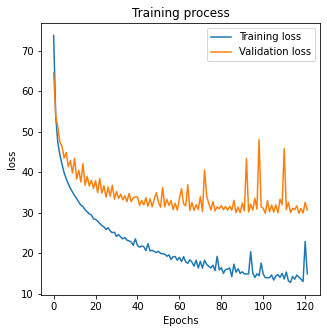

In [46]:
show_training_process(history=model_history, metric_name='loss',
                      figure_id=1)

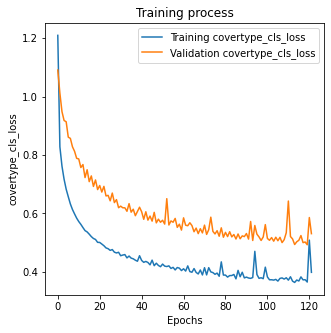

In [47]:
show_training_process(history=model_history, metric_name='covertype_cls_loss',
                      figure_id=2)

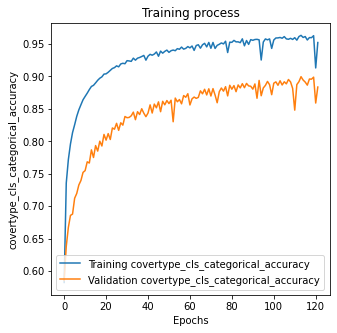

In [48]:
show_training_process(history=model_history,
                      metric_name='covertype_cls_categorical_accuracy',
                      figure_id=3)

In [49]:
del trainset_gen, validset_gen

In [50]:
del X_train, y_train, X_valid_quantized, X_train_quantized

In [51]:
del trainable_nn

In [52]:
gc.collect()

10416

In [53]:
valid_probas = predict_proba(
    X=X_valid, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/863 [00:00<?, ?it/s]

In [54]:
print(classification_report(y_true=y_valid, y_pred=np.argmax(valid_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8879    0.8867    0.8873     10063
           1     0.9247    0.8785    0.9010     13457
           2     0.9035    0.9482    0.9253      1698
           3     0.6153    0.9645    0.7513       451
           4     0.7856    0.9370    0.8546       825
           5     0.8405    0.9846    0.9069       974
           6     0.8133    0.9313    0.8683       131

    accuracy                         0.8929     27599
   macro avg     0.8244    0.9330    0.8707     27599
weighted avg     0.8972    0.8929    0.8937     27599



In [55]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=1, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [56]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8888    0.8849    0.8868     10592
           1     0.9226    0.8815    0.9016     14165
           2     0.9094    0.9430    0.9259      1788
           3     0.6331    0.9516    0.7603       475
           4     0.7893    0.9493    0.8619       868
           5     0.8467    0.9903    0.9128      1026
           6     0.8176    0.9489    0.8784       137

    accuracy                         0.8939     29051
   macro avg     0.8296    0.9356    0.8754     29051
weighted avg     0.8976    0.8939    0.8945     29051



In [57]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=10, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [58]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8881    0.8852    0.8867     10592
           1     0.9229    0.8810    0.9014     14165
           2     0.9089    0.9430    0.9256      1788
           3     0.6339    0.9516    0.7609       475
           4     0.7900    0.9493    0.8624       868
           5     0.8453    0.9903    0.9120      1026
           6     0.8176    0.9489    0.8784       137

    accuracy                         0.8937     29051
   macro avg     0.8295    0.9356    0.8753     29051
weighted avg     0.8974    0.8937    0.8943     29051



In [59]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=100, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/908 [00:00<?, ?it/s]

In [60]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.8886    0.8845    0.8865     10592
           1     0.9224    0.8814    0.9014     14165
           2     0.9089    0.9435    0.9259      1788
           3     0.6322    0.9516    0.7597       475
           4     0.7906    0.9482    0.8622       868
           5     0.8467    0.9903    0.9128      1026
           6     0.8176    0.9489    0.8784       137

    accuracy                         0.8937     29051
   macro avg     0.8296    0.9355    0.8753     29051
weighted avg     0.8974    0.8937    0.8943     29051

